# Weather Prediction Model Training

This notebook trains an LSTM (Long Short-Term Memory) neural network to predict weather conditions based on historical data. The model will be deployed to an edge device for real-time weather forecasting.

## Model Overview
- **Input**: Historical weather data (30-day lookback)
- **Features**: Precipitation, Average Temperature, Max Temperature, Min Temperature, Seasonal patterns
- **Output**: Next day weather predictions
- **Model**: LSTM with TensorFlow Lite optimization for edge deployment

## Steps:
1. Data Loading and Preprocessing
2. Feature Engineering 
3. Model Architecture Design
4. Training and Validation
5. Model Evaluation
6. TensorFlow Lite Conversion
7. Model Export for Edge Deployment

In [5]:
# Data Loading and Initial Exploration
import pandas as pd
import numpy as np
import os

# Check if dataset exists
dataset_path = '../datasets/weather.csv'
if not os.path.exists(dataset_path):
    print(f"Dataset not found at {dataset_path}")
    print("Please ensure the weather.csv file is in the datasets folder")
else:
    print(f"Loading dataset from {dataset_path}")
    weather = pd.read_csv(dataset_path, index_col="DATE")
    print(f"Dataset shape: {weather.shape}")
    print(f"Date range: {weather.index.min()} to {weather.index.max()}")
    print(f"Columns: {list(weather.columns)}")
    weather.head()

Loading dataset from ../datasets/weather.csv
Dataset shape: (17247, 6)
Date range: 1975-01-01 to 2025-01-26
Columns: ['STATION', 'NAME', 'PRCP', 'TAVG', 'TMAX', 'TMIN']


In [6]:
# Data Quality Analysis
print("🔍 Analyzing data quality...")
print("\n📊 Missing Data Percentage:")
null_pct = weather.apply(pd.isnull).sum() / len(weather) * 100
for col, pct in null_pct.items():
    if pct > 0:
        print(f"  {col}: {pct:.2f}%")
    else:
        print(f"  {col}: ✅ No missing data")

print(f"\n📈 Total records: {len(weather):,}")

# Convert index to datetime if it's not already
if not isinstance(weather.index, pd.DatetimeIndex):
    weather.index = pd.to_datetime(weather.index)

print(f"📅 Years of data: {(weather.index.max() - weather.index.min()).days / 365.25:.1f}")

# Display basic statistics
print("\n📊 Data Summary:")
weather.describe()

🔍 Analyzing data quality...

📊 Missing Data Percentage:
  STATION: ✅ No missing data
  NAME: ✅ No missing data
  PRCP: 51.80%
  TAVG: 3.60%
  TMAX: 25.85%
  TMIN: 24.76%

📈 Total records: 17,247
📅 Years of data: 50.1

📊 Data Summary:


,PRCP,TAVG,TMAX,TMIN
count,8313.000000,16626.000000,12789.000000,12976.000000
mean,3.833694,19.083586,25.686066,12.890436
std,10.757854,3.406852,3.447130,3.956947
min,0.000000,6.300000,11.500000,-2.600000
25%,0.000000,16.700000,23.400000,9.700000
50%,0.000000,19.700000,26.000000,13.700000
75%,2.000000,21.500000,28.100000,16.300000
max,176.000000,29.600000,36.700000,21.600000


In [7]:
weather.columns = weather.columns.str.lower()
weather

,station,name,prcp,tavg,tmax,tmin
DATE,,,,,,
1975-01-01,ZI000067775,"HARARE KUTSAGA, ZI",0.5,NaN,24.5,15.5
1975-01-02,ZI000067775,"HARARE KUTSAGA, ZI",9.9,NaN,28.0,15.5
1975-01-03,ZI000067775,"HARARE KUTSAGA, ZI",43.2,NaN,23.5,15.8
1975-01-04,ZI000067775,"HARARE KUTSAGA, ZI",0.6,NaN,23.2,15.5
1975-01-05,ZI000067775,"HARARE KUTSAGA, ZI",0.0,NaN,24.1,13.6
...,...,...,...,...,...,...
2025-01-22,ZI000067775,"HARARE KUTSAGA, ZI",1.0,20.6,NaN,16.6
2025-01-23,ZI000067775,"HARARE KUTSAGA, ZI",0.0,21.9,26.2,NaN
2025-01-24,ZI000067775,"HARARE KUTSAGA, ZI",NaN,21.1,25.1,16.6


In [8]:
weather = weather.ffill()
weather.apply(pd.isnull).sum() / len(weather) * 100

station    0.000000
name       0.000000
prcp       0.000000
tavg       0.162347
tmax       0.000000
tmin       0.000000
dtype: float64

In [9]:
# deal with 0.16% null values in tavg
weather['tavg'] = weather['tavg'].fillna(weather['tavg'].mean())

In [10]:
weather.apply(pd.isnull).sum() / len(weather) * 100

station    0.0
name       0.0
prcp       0.0
tavg       0.0
tmax       0.0
tmin       0.0
dtype: float64

In [11]:
weather.index = pd.to_datetime(weather.index)

In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load daily data (columns: date, prcp, tavg, tmax, tmin)
data = weather.reset_index()
data.columns = data.columns.str.lower()
data = data[['date', 'prcp', 'tavg', 'tmax', 'tmin']]
data['date'] = pd.to_datetime(data['date'])
data

,date,prcp,tavg,tmax,tmin
0,1975-01-01,0.5,19.049364,24.5,15.5
1,1975-01-02,9.9,19.049364,28.0,15.5
2,1975-01-03,43.2,19.049364,23.5,15.8
3,1975-01-04,0.6,19.049364,23.2,15.5
4,1975-01-05,0.0,19.049364,24.1,13.6
...,...,...,...,...,...
17242,2025-01-22,1.0,20.600000,24.1,16.6
17243,2025-01-23,0.0,21.900000,26.2,16.6
17244,2025-01-24,0.0,21.100000,25.1,16.6
17245,2025-01-25,0.0,21.400000,25.1,16.6


In [13]:
# Add temporal features (critical for daily data!)
data['day_of_year_sin'] = np.sin(2 * np.pi * data['date'].dt.dayofyear / 365)
data['day_of_year_cos'] = np.cos(2 * np.pi * data['date'].dt.dayofyear / 365)

# Target: Predict next day's prcp, tavg, tmax, tmin
target_cols = ['prcp', 'tavg', 'tmax', 'tmin']
features = ['prcp', 'tavg', 'tmax', 'tmin', 'day_of_year_sin', 'day_of_year_cos']

In [14]:
# Normalization
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data[features])
joblib.dump(scaler, 'scaler_params.joblib')  # Save for Pi

['scaler_params.joblib']

In [15]:
def create_daily_dataset(data, lookback=30, forecast=1):
    X, Y = [], []
    for i in range(len(data)-lookback-forecast):
        X.append(data[i:i+lookback])
        Y.append(data[i+lookback:i+lookback+forecast, :4])  # All 4 targets
    return np.array(X), np.array(Y)

X, Y = create_daily_dataset(scaled)
print(f"Input shape: {X.shape}, Target shape: {Y.shape}")  # (n_samples, 30, 6), (n_samples, 1, 4)

Input shape: (17216, 30, 6), Target shape: (17216, 1, 4)


In [16]:
# Enhanced LSTM Model Architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np

print("🧠 Building Enhanced LSTM Model...")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

model = Sequential([
    # First LSTM layer with return sequences
    LSTM(64, return_sequences=True, input_shape=(30, 6), name='lstm_1'),
    BatchNormalization(),
    Dropout(0.2),
    
    # Second LSTM layer
    LSTM(32, return_sequences=False, name='lstm_2'),
    BatchNormalization(),
    Dropout(0.2),
    
    # Dense layers for predictions
    Dense(16, activation='relu', name='dense_1'),
    Dropout(0.1),
    Dense(4, name='output')  # Predicts prcp, tavg, tmax, tmin for next day
])

# Compile with custom optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(
    loss='mse', 
    optimizer=optimizer,
    metrics=['mae']
)

print("✅ Model compiled successfully!")
print("\n🏗️ Model Architecture:")
model.summary()

2025-07-01 23:50:02.303382: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-01 23:50:02.376339: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-01 23:50:02.377374: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-01 23:50:03.510593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-07-01 23:50:03.510593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


🧠 Building Enhanced LSTM Model...
✅ Model compiled successfully!

🏗️ Model Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 64)            18176     
                                                                 
 batch_normalization (Batch  (None, 30, 64)            256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
✅ Model compiled successfully!

🏗️ Model Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 64)            18176     
                                                                 
 batch_normalization (Ba

🚀 Starting model training...
Epoch 1/100
430/431 [============================>.] - ETA: 0s - loss: 0.1940 - mae: 0.3204
Epoch 1: val_loss improved from inf to 0.05250, saving model to best_weather_model.h5

Epoch 1: val_loss improved from inf to 0.05250, saving model to best_weather_model.h5
431/431 [==============================] - 20s 35ms/step - loss: 0.1939 - mae: 0.3203 - val_loss: 0.0525 - val_mae: 0.1992 - lr: 0.0010
Epoch 2/100
431/431 [==============================] - 20s 35ms/step - loss: 0.1939 - mae: 0.3203 - val_loss: 0.0525 - val_mae: 0.1992 - lr: 0.0010
Epoch 2/100
  3/431 [..............................] - ETA: 17s - loss: 0.0630 - mae: 0.1940

/home/tauya/Desktop/Project Final/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


430/431 [============================>.] - ETA: 0s - loss: 0.0447 - mae: 0.1649
Epoch 2: val_loss improved from 0.05250 to 0.02430, saving model to best_weather_model.h5

Epoch 2: val_loss improved from 0.05250 to 0.02430, saving model to best_weather_model.h5
431/431 [==============================] - 14s 32ms/step - loss: 0.0447 - mae: 0.1648 - val_loss: 0.0243 - val_mae: 0.1317 - lr: 0.0010
Epoch 3/100
431/431 [==============================] - 14s 32ms/step - loss: 0.0447 - mae: 0.1648 - val_loss: 0.0243 - val_mae: 0.1317 - lr: 0.0010
Epoch 3/100
430/431 [============================>.] - ETA: 0s - loss: 0.0277 - mae: 0.1302
Epoch 3: val_loss improved from 0.02430 to 0.01989, saving model to best_weather_model.h5

Epoch 3: val_loss improved from 0.02430 to 0.01989, saving model to best_weather_model.h5
431/431 [==============================] - 14s 32ms/step - loss: 0.0277 - mae: 0.1301 - val_loss: 0.0199 - val_mae: 0.1143 - lr: 0.0010
Epoch 4/100
431/431 [=========================

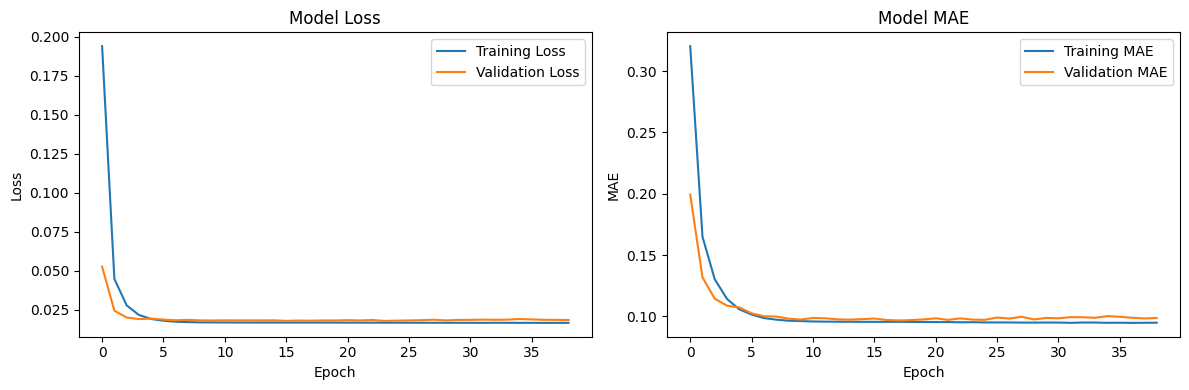

📊 Final Training Loss: 0.0165
📊 Final Validation Loss: 0.0183


In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

print("🚀 Starting model training...")

# Enhanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_weather_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train the model
history = model.fit(
    X, Y, 
    epochs=100, 
    batch_size=32,  # Increased batch size for better training
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("✅ Training completed!")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

print(f"📊 Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"📊 Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

In [18]:
# TensorFlow Lite Model Conversion and Optimization
import tensorflow as tf
import os
import numpy as np

print("🔄 Converting to TensorFlow Lite...")

# Convert to TensorFlow Lite with optimizations
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply optimizations for edge deployment
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

# Critical for LSTM models on edge devices
converter._experimental_lower_tensor_list_ops = False
converter.experimental_enable_resource_variables = True

# Convert the model
try:
    tflite_model = converter.convert()
    print("✅ TensorFlow Lite conversion successful!")
    
    # Save the model
    model_path = 'weather_prediction_model.tflite'
    with open(model_path, 'wb') as f:
        f.write(tflite_model)
    
    # Check model size
    model_size = os.path.getsize(model_path) / 1024  # Size in KB
    print(f"📦 Model size: {model_size:.1f} KB")
    
    # Test the TFLite model
    print("\n🧪 Testing TensorFlow Lite Model:")
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    print(f"Input shape: {input_details[0]['shape']}")
    print(f"Output shape: {output_details[0]['shape']}")
    
    # Test with sample data
    test_input = np.random.random((1, 30, 6)).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], test_input)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    print(f"✅ TFLite model test successful!")
    print(f"Test output shape: {output_data.shape}")
    
except Exception as e:
    print(f"❌ Conversion failed: {e}")
    print("Trying alternative conversion...")
    
    # Alternative conversion without some optimizations
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    tflite_model = converter.convert()
    
    with open('weather_prediction_model_basic.tflite', 'wb') as f:
        f.write(tflite_model)
    print("✅ Basic TensorFlow Lite conversion successful!")

🔄 Converting to TensorFlow Lite...
INFO:tensorflow:Assets written to: /tmp/tmplh8xteb5/assets
INFO:tensorflow:Assets written to: /tmp/tmplh8xteb5/assets


INFO:tensorflow:Assets written to: /tmp/tmplh8xteb5/assets


✅ TensorFlow Lite conversion successful!
📦 Model size: 52.8 KB

🧪 Testing TensorFlow Lite Model:
Input shape: [ 1 30  6]
Output shape: [1 4]
✅ TFLite model test successful!
Test output shape: (1, 4)


2025-07-02 00:02:42.015513: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-07-02 00:02:42.015556: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-07-02 00:02:42.015920: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplh8xteb5
2025-07-02 00:02:42.036962: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-07-02 00:02:42.037004: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmplh8xteb5
2025-07-02 00:02:42.110294: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2025-07-02 00:02:42.132812: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-07-02 00:02:42.401555: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmplh8xteb5
2025-07

In [19]:
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load the scaler you saved during training
scaler = joblib.load('scaler_params.joblib')

print("📊 Model Evaluation Results:")
print("=" * 50)

# Make predictions on test set
test_size = int(0.2 * len(X))
X_train, X_test = X[:-test_size], X[-test_size:]
Y_train, Y_test = Y[:-test_size], Y[-test_size:]

predictions = model.predict(X_test)

# Calculate metrics for each target variable
target_names = ['Precipitation', 'Avg Temp', 'Max Temp', 'Min Temp']
for i, target in enumerate(target_names):
    y_true = Y_test[:, 0, i]  # Actual values
    y_pred = predictions[:, i]  # Predicted values
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{target}:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²:   {r2:.4f}")

# Display scaler parameters for edge deployment
print("\n🔧 Scaler Parameters for Edge Deployment:")
print("=" * 50)
print("Scale values:", scaler.scale_.tolist())
print("Min values:", scaler.min_.tolist())

# Test prediction function
print("\n🧪 Testing Prediction Function:")
print("=" * 50)
test_data = np.array([[10, 20, 25, 15, 0.5, 0.8]])  # Sample input
scaled_test = scaler.transform(test_data)
print(f"Input: Prcp=10, Tavg=20, Tmax=25, Tmin=15")
print(f"Scaled input: {scaled_test[0]}")

# Create a sequence for prediction (last 30 days)
test_sequence = np.tile(scaled_test, (30, 1)).reshape(1, 30, 6)
prediction = model.predict(test_sequence, verbose=0)
print(f"Raw prediction: {prediction[0]}")

# Inverse transform for actual values
pred_with_features = np.zeros((1, 6))
pred_with_features[0, :4] = prediction[0]
pred_denormalized = scaler.inverse_transform(pred_with_features)[0, :4]
print(f"Predicted next day: Prcp={pred_denormalized[0]:.1f}, Tavg={pred_denormalized[1]:.1f}°C, Tmax={pred_denormalized[2]:.1f}°C, Tmin={pred_denormalized[3]:.1f}°C")

📊 Model Evaluation Results:
108/108 [==============================] - 3s 12ms/step

Precipitation:
  MAE:  0.0194
  RMSE: 0.0372
  R²:   -0.0655

Avg Temp:
  MAE:  0.1291
  RMSE: 0.1561
  R²:   0.0003

Max Temp:
  MAE:  0.1217
  RMSE: 0.1430
  R²:   -0.1320

Min Temp:
  MAE:  0.1190
  RMSE: 0.1573
  R²:   0.0021

🔧 Scaler Parameters for Edge Deployment:
Scale values: [0.005681818181818182, 0.04291845493562232, 0.03968253968253968, 0.04132231404958677, 0.5000046301747816, 0.5000092603924402]
Min values: [0.0, -0.27038626609442057, -0.45634920634920634, 0.10743801652892561, 0.5, 0.49999073960755985]

🧪 Testing Prediction Function:
Input: Prcp=10, Tavg=20, Tmax=25, Tmin=15
Scaled input: [0.05681818 0.58798283 0.53571429 0.72727273 0.75000232 0.89999815]
Raw prediction: [0.01579096 0.5491368  0.5673217  0.6544491 ]
Predicted next day: Prcp=2.8, Tavg=19.1°C, Tmax=25.8°C, Tmin=13.2°C

Precipitation:
  MAE:  0.0194
  RMSE: 0.0372
  R²:   -0.0655

Avg Temp:
  MAE:  0.1291
  RMSE: 0.1561
  R²:

/home/tauya/Desktop/Project Final/.venv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [20]:
# In your training environment
test_data = np.array([[10, 20, 25, 0, 0, 0]])  # Sample [prcp, tavg, tmax, tmin, time_sin, time_cos]
print(scaler.transform(test_data))

# Edge Deployment Preparation
import json
import os

print("📦 Preparing files for edge deployment...")

# Create deployment configuration
deployment_config = {
    "model_info": {
        "name": "weather_prediction_lstm",
        "version": "1.0.0",
        "input_shape": [1, 30, 6],
        "output_shape": [1, 4],
        "features": ["precipitation", "avg_temp", "max_temp", "min_temp", "day_sin", "day_cos"],
        "targets": ["next_precipitation", "next_avg_temp", "next_max_temp", "next_min_temp"]
    },
    "preprocessing": {
        "lookback_days": 30,
        "scale_values": scaler.scale_.tolist(),
        "min_values": scaler.min_.tolist(),
        "feature_names": ["prcp", "tavg", "tmax", "tmin", "day_of_year_sin", "day_of_year_cos"]
    },
    "performance": {
        "training_loss": float(history.history['loss'][-1]),
        "validation_loss": float(history.history['val_loss'][-1]),
        "model_size_kb": os.path.getsize('weather_prediction_model.tflite') / 1024
    }
}

# Save configuration
with open('model_config.json', 'w') as f:
    json.dump(deployment_config, f, indent=2)

print("✅ Files created for edge deployment:")
print("📁 weather_prediction_model.tflite - Main model file")
print("📁 scaler_params.joblib - Preprocessing parameters")
print("📁 model_config.json - Deployment configuration")

# Create a simple prediction function for edge devices
edge_prediction_code = '''
# Edge Device Prediction Function
import numpy as np
import tensorflow as tf
import json

class WeatherPredictor:
    def __init__(self, model_path, config_path):
        # Load TFLite model
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.interpreter.allocate_tensors()
        
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        
        # Load configuration
        with open(config_path, 'r') as f:
            self.config = json.load(f)
        
        self.scale_values = np.array(self.config['preprocessing']['scale_values'])
        self.min_values = np.array(self.config['preprocessing']['min_values'])
    
    def normalize_input(self, data):
        """Normalize input data using saved scaler parameters"""
        return (data - self.min_values) / self.scale_values
    
    def denormalize_output(self, data):
        """Denormalize output predictions"""
        # Only denormalize the first 4 features (weather targets)
        scale_subset = self.scale_values[:4]
        min_subset = self.min_values[:4]
        return (data * scale_subset) + min_subset
    
    def predict(self, weather_sequence):
        """
        Predict next day weather
        weather_sequence: array of shape (30, 6) with last 30 days of weather data
        Returns: [precipitation, avg_temp, max_temp, min_temp] for next day
        """
        # Normalize input
        normalized_input = self.normalize_input(weather_sequence)
        
        # Reshape for model input
        input_data = normalized_input.reshape(1, 30, 6).astype(np.float32)
        
        # Run prediction
        self.interpreter.set_tensor(self.input_details[0]['index'], input_data)
        self.interpreter.invoke()
        output_data = self.interpreter.get_tensor(self.output_details[0]['index'])
        
        # Denormalize output
        prediction = self.denormalize_output(output_data[0])
        
        return {
            'precipitation': float(prediction[0]),
            'avg_temperature': float(prediction[1]),
            'max_temperature': float(prediction[2]),
            'min_temperature': float(prediction[3])
        }

# Example usage:
# predictor = WeatherPredictor('weather_prediction_model.tflite', 'model_config.json')
# result = predictor.predict(last_30_days_data)
'''

with open('edge_predictor.py', 'w') as f:
    f.write(edge_prediction_code)

print("📁 edge_predictor.py - Ready-to-use prediction class for edge devices")

print("\n🎯 Model Training Complete!")
print("=" * 50)
print("Your weather prediction model is ready for deployment!")
print("Transfer these files to your edge device:")
print("  • weather_prediction_model.tflite")
print("  • model_config.json") 
print("  • edge_predictor.py")
print("\nThe model can predict tomorrow's weather based on the last 30 days of data.")

[[0.05681818 0.58798283 0.53571429 0.10743802 0.5        0.49999074]]
📦 Preparing files for edge deployment...
✅ Files created for edge deployment:
📁 weather_prediction_model.tflite - Main model file
📁 scaler_params.joblib - Preprocessing parameters
📁 model_config.json - Deployment configuration
📁 edge_predictor.py - Ready-to-use prediction class for edge devices

🎯 Model Training Complete!
Your weather prediction model is ready for deployment!
Transfer these files to your edge device:
  • weather_prediction_model.tflite
  • model_config.json
  • edge_predictor.py

The model can predict tomorrow's weather based on the last 30 days of data.


/home/tauya/Desktop/Project Final/.venv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
